In [1]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot

import os
import scipy
import awkward as ak
import time
import subprocess
GIT_REPO = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
sys.path.append(GIT_REPO + '/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import *

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [10]:
limitTrees =OrderedDict()
dataCards = OrderedDict()


datacard_version = 'v4'
cardDir=f"/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_run3HMT/csccsc/{datacard_version}/"
treeDir = cardDir.replace("datacards","limitTrees")

ctaus = np.array([1,3,5,10,30,50,100,300,500,1000,1500,2000,3000,5000,8000,10000,30000,50000,100000])
mass = [15,23,30,40,55]
decays = ['B']

            
if 'csccsc' in cardDir:
    NHIT_CUT = 190
    DPHI_CUT = 2.8
else:
    # NHIT_CUT = 100
    # DPHI_CUT = 2.5
    NHIT_CUT = 90
    DPHI_CUT = 2.8

### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.025', '0.160','0.500','0.840','0.975']

for decay in decays:
    for m in mass:
        key = f"ggH_HToSS_STo4{decay}_ms{m}"
        limitTrees[key] = {}
        dataCards[key] = {}

        for ct in ctaus:
            card_name = f'ggH_HToSS_STo4{decay}_ms{m}_ctau{ct}_nhits{NHIT_CUT}_dphi'+str(round(DPHI_CUT,1)).replace(".","p")
            dataCards[key][ct] = f'{cardDir}/{card_name}.txt'
            limitTrees[key][ct] = f'{treeDir}/higgsCombine.{card_name}.AsymptoticLimits.mH120.root'


norms = []
limits = {}
for i,m in enumerate(limitTrees.keys()):
    limits[m] = np.ones((len(ctaus), 5))*1000000
    for j, k in enumerate(limitTrees[m].keys()):

        if not os.path.isfile(limitTrees[m][k]):
            # print(limitTrees[m][k])
            continue
        if not os.path.isfile(dataCards[m][k]):
            # print(dataCards[m][k])
            continue
        line = open(dataCards[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        
        if signal_norm == 0:continue
        
        if len(uproot.open(limitTrees[m][k]).keys()) == 2:
            T = uproot.open(limitTrees[m][k])['limit']                
            if len(np.array(T['limit'].array())>0):limits[m][j] = np.array(T['limit'].array())/signal_norm
    limits[m] = np.array(limits[m])
print(ctaus)

[     1      3      5     10     30     50    100    300    500   1000
   1500   2000   3000   5000   8000  10000  30000  50000 100000]


# load other limits

In [11]:
file_dir = '/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'


# ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
# ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'
# ms_8 = file_dir + 'atlas_mh125_mx8_ms.csv'


other_limits = {}

# other_limits['EXO-21-008_csccsc'] = np.genfromtxt(file_dir + 'EXO-21-008-BB_15_CSCCSC.csv' , delimiter=',')
other_limits['EXO-21-008_cscdt'] = np.genfromtxt(file_dir + 'EXO-21-008-BB_15_DTCSC.csv', delimiter=',')
# other_limits['EXO-21-008_dtdt'] = np.genfromtxt(file_dir + 'EXO-21-008-BB_15_DTDT.csv', delimiter=',')
other_limits['EXO-21-008_2tag'] = np.genfromtxt(file_dir + 'EXO-21-008-BB_15_combined.csv', delimiter=',')

# other_limits['EXO-21-008_all'] = np.genfromtxt(file_dir + 'limitsbbbb_m15_hybridNew.txt', delimiter='\t')


# plot expected limit 

B
ggH_HToSS_STo4B_ms15 0.0061570630161825275
[3.27668334e+05 3.67241788e+02 1.65225768e+00 1.99033245e-02
 8.45007160e-03 6.15706302e-03 7.34185889e-03 9.28266371e-03
 1.45434157e-02 2.96938841e-02 6.30860773e-02 1.09889055e-01
 8.14584810e-01 2.17342635e+00]
ggH_HToSS_STo4B_ms23 0.0058377089565077485
ggH_HToSS_STo4B_ms30 0.005567513124557652
ggH_HToSS_STo4B_ms40 0.005335489327194309
ggH_HToSS_STo4B_ms55 0.01731270923624906
True
50 fb^{-1} (13.6 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


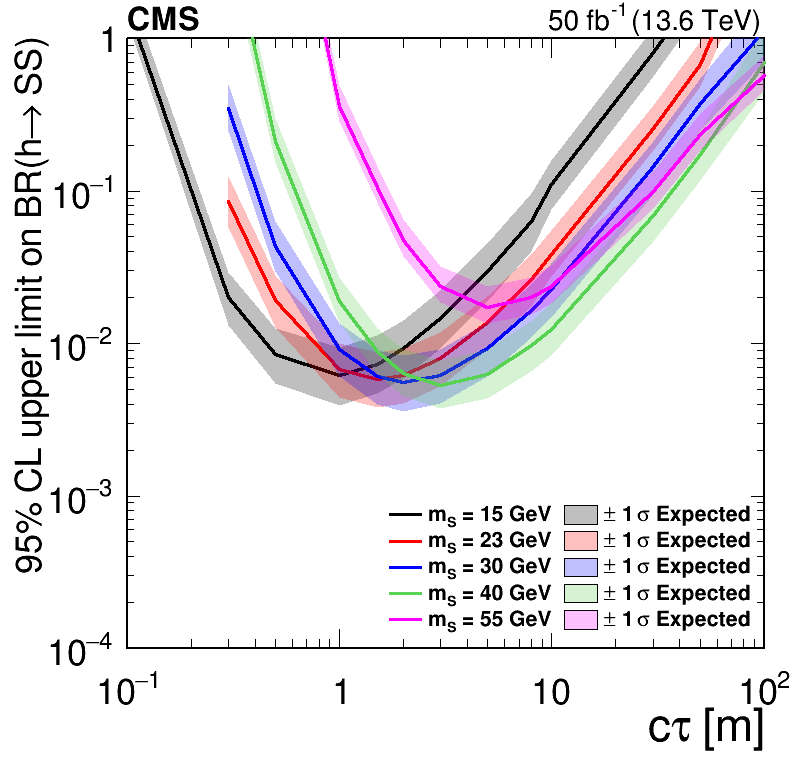

In [12]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


opac_1sig = 0.25
opac_2sig = 0.1
for decay in decays:
    print(decay)
    leg = rt.TLegend(0.48,0.18,0.95,0.35)
    leg2 = rt.TLegend(0.18,0.20,0.40,0.33)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    leg2.SetTextSize(0.032)
    leg2.SetBorderSize(0)
    leg2.SetEntrySeparation(0.01)
    
    
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)

    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
#     print(ctaus_m)
    h = {}
    h_exp1sig = {}
    h_exp2sig = {}
    h_obs = {}
    h_others = {}
    sample_temp = []
    for m in mass:
        sample_temp.append(f"ggH_HToSS_STo4{decay}_ms{m}")

    for i, m in enumerate(sample_temp):
        cond = limits[m][:,2] < 1000000
        

        h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
        h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
        mass_str = m[m.find('ms')+2:].replace('p','.')
        print(m,np.min(limits[m][:,2][cond]))
        if '15' in m:print(limits[m][:,2][cond])
        leg.AddEntry(h[m], "m_{S} = "+mass_str+" GeV", "L")
        if leg2.GetNRows() == 0:leg2.AddEntry(h[m], "Median Expected", "L")

        leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')

        h_exp1sig[m].SetFillColorAlpha(std_color_list[i],opac_1sig)
        h[m].SetLineColor(std_color_list[i])
        h[m].SetMarkerColor(std_color_list[i])

        h[m].SetLineWidth(3)

        h[m].SetLineStyle(1)
        h[m].SetLineWidth(3)
        if decay == 'd' or decay == 'B' or decay == 'Tau': h[m].GetXaxis().SetLimits(0.1,100.0)
        else: h[m].GetXaxis().SetLimits(0.0001,100.0)
        h[m].GetYaxis().SetRangeUser(1e-4,1)

        h[m].GetXaxis().SetTitleOffset(1)
        h[m].GetYaxis().SetTitleSize(0.05)
        h[m].GetYaxis().SetTitleOffset(1.5)



    for i,m in enumerate(h.keys()):
        h[m].Draw('LA' if i == 0 else 'Lsame')
#         h_obs[m].Draw('LPsame')
        h_exp1sig[m].Draw('Fsame')



    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 0
    CMS_lumi.extraText   = "Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 5, iPos)


    leg.SetNColumns(2)

    leg.Draw()
#     leg2.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)


    latex = rt.TLatex()
    latex.SetTextSize(0.06)
    latex.SetTextFont(42)

    if decay == 'd': latex.DrawLatex(200,0.002,  "S #rightarrow d#bar{d}")
    elif decay == 'B': latex.DrawLatex(200,0.002, "S #rightarrow b#bar{b}")
    elif decay == 'Tau': latex.DrawLatex(200,0.002, "S #rightarrow #tau^{+}#tau^{-}")
   

    # output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits/'+version+'/'+dc_version+'/'+unblind+'/'
    # if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+mode+'_HToSSTo'+decay


#     c.SaveAs(name+'_expected.png')
#     c.SaveAs(name+'_expected.C')
#     c.SaveAs(name+'_expected.pdf')

    tdrstyle.setTDRStyle()
    c.Draw()

# Comparison with Previous result (15 GeV)

B
True
50 fb^{-1} (13.6 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


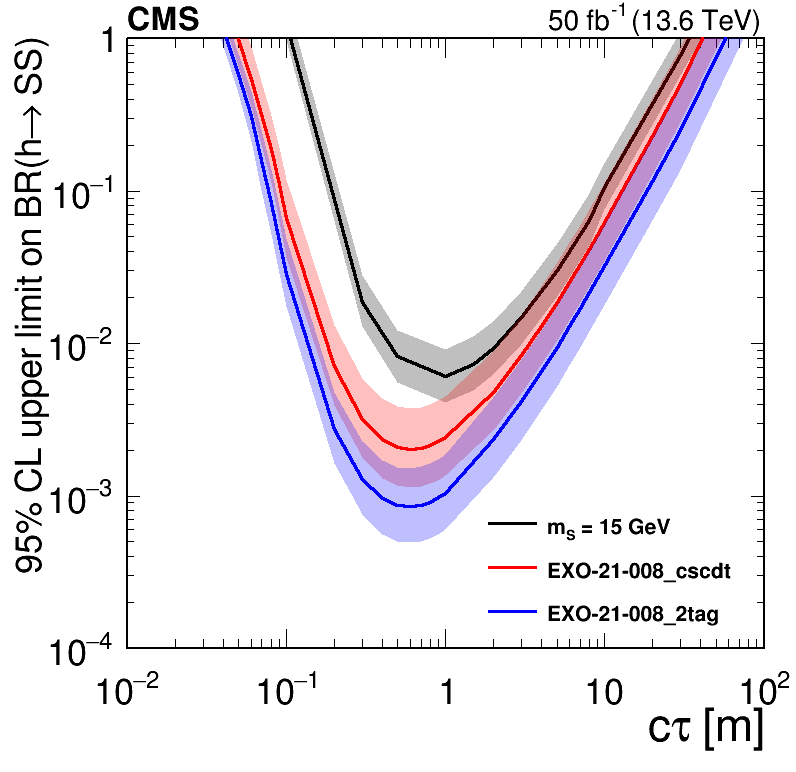

In [8]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


opac_1sig = 0.25
opac_2sig = 0.1
for decay in decays:
    print(decay)
    leg = rt.TLegend(0.6,0.18,0.95,0.35)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
  
    
    
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)

    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
#     print(ctaus_m)
    h = {}
    h_exp1sig = {}
    h_exp2sig = {}
    h_obs = {}
    h_others = {}
    h_others_1sig = {}
    sample_temp = []
    for m in mass:
        if m == 15:sample_temp.append(f"ggH_HToSS_STo4{decay}_ms{m}")
    for i, m in enumerate(sample_temp):
        cond = limits[m][:,2] < 1000000
        

        h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
        h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
        mass_str = m[m.find('ms')+2:].replace('p','.')


    
        
        leg.AddEntry(h[m], "m_{S} = "+mass_str+" GeV", "L")
        if leg2.GetNRows() == 0:leg2.AddEntry(h[m], "Median Expected", "L")

        # leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')

#         if len(sample_temp) == 3: 
        h_exp1sig[m].SetFillColorAlpha(std_color_list[i],opac_1sig)
        h[m].SetLineColor(std_color_list[i])
        h[m].SetMarkerColor(std_color_list[i])
        h[m].SetLineStyle(1)
        h[m].SetLineWidth(3)
        if decay == 'd' or decay == 'B' or decay == 'Tau': h[m].GetXaxis().SetLimits(0.01,100.0)
        else: h[m].GetXaxis().SetLimits(0.0001,100.0)
        h[m].GetYaxis().SetRangeUser(1e-4,1)

        h[m].GetXaxis().SetTitleOffset(1)
        h[m].GetYaxis().SetTitleSize(0.05)
        h[m].GetYaxis().SetTitleOffset(1.5)



    for i,m in enumerate(h.keys()):
        h[m].Draw('LA' if i == 0 else 'Lsame')
        h_exp1sig[m].Draw('Fsame')

        

    for i,k in enumerate(other_limits.keys()):

            
            
        h_others[k] = create_TGraph(other_limits[k][:,0],other_limits[k][:,3],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        h_others_1sig[k] = create_TGraph(np.hstack((other_limits[k][:,0], np.flip(other_limits[k][:,0]))),\
                                         np.hstack((other_limits[k][:,2], np.flip(other_limits[k][:,4]))),  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        leg.AddEntry(h_others[k], k, 'L')
        h_others[k].SetLineWidth(3)

        h_others[k].SetLineColor(std_color_list[i+1])
        h_others[k].SetMarkerColor(std_color_list[i+1])
        h_others_1sig[k].SetFillColorAlpha(std_color_list[i+1], opac_1sig)
        h_others[k].Draw('Lsame')
        h_others_1sig[k].Draw('Fsame')  
        
    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 0
    CMS_lumi.extraText   = "Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 5, iPos)


    # leg.SetNColumns(2)

    leg.Draw()
#     leg2.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)


    latex = rt.TLatex()
    latex.SetTextSize(0.06)
    latex.SetTextFont(42)

    if decay == 'd': latex.DrawLatex(200,0.002,  "S #rightarrow d#bar{d}")
    elif decay == 'B': latex.DrawLatex(200,0.002, "S #rightarrow b#bar{b}")
    elif decay == 'Tau': latex.DrawLatex(200,0.002, "S #rightarrow #tau^{+}#tau^{-}")
    # elif decay == 'EE': latex.DrawLatex(1,0.002, "S #rightarrow e^{+}e^{-}")
    # elif decay == 'GammaGamma': latex.DrawLatex(1,0.002, "S #rightarrow #gamma#gamma")
    # elif decay == 'KPlusKMinus': latex.DrawLatex(1,0.002, "S #rightarrow K^{+}K^{-}")
    # elif decay == 'K0K0': latex.DrawLatex(1,0.002, "S #rightarrow K^{0}K^{0}")
    # elif decay == 'Pi0Pi0': latex.DrawLatex(1,0.002, "S #rightarrow #pi^{0}#pi^{0}")
    # elif decay == 'PiPlusPiMinus': latex.DrawLatex(1,0.002, "S #rightarrow #pi^{+}#pi^{-}")

    # output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/limits/'+version+'/'+dc_version+'/'+unblind+'/'
    # if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+mode+'_HToSSTo'+decay


#     c.SaveAs(name+'_expected.png')
#     c.SaveAs(name+'_expected.C')
#     c.SaveAs(name+'_expected.pdf')

    tdrstyle.setTDRStyle()
    c.Draw()